# Applied Machine Learning to Titanic Deaths 

The goal of this project is to predict passenger survival on the Titanic using machine learning. This is a binary classification problem, because a passenger either survived or not. The [Titanic dataset](https://www.kaggle.com/c/titanic/data) contains travel and demographic information about the passengers, such as sex, age, passenger class, and ticket price. Both the linear Logistic Regression and the tree-based Random Forest were applied to model the survival and compare how well the features predict. 

Firstly, the dataset gets loaded into a Pandas dataframe and inspected. 

In [1]:
import pandas as pd 

titanic_data = pd.read_csv("titanic.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The dataset gets standardly split into X_train, X_test, y_train, and y_test. An 80/20 split is used because it is a common balance between having enough data to train the model and having a sufficient sample to reliably evaluate it. The features Name, Ticket, and Cabin are excluded from the training data because they are either not useful or would require deeper feature engineering. Categorical and numerical features are stored separately for later purposes. 

In [2]:
from sklearn.model_selection import train_test_split

num_features = ["Pclass", "Age", "Fare", "SibSp", "Parch"]
cat_features = ["Sex", "Embarked"]

y = titanic_data.Survived
X = titanic_data[num_features + cat_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

To make the code simpler and less prone to bugs, a pipeline is used. The column Age is missing some values, so the missing values are replaced by the mean value, a standard imputing strategy. Some values in Embarked are missing, too; here, the most frequent value gets imputed. Furthermore, the numerical features are normalized, which helps gradient based models, like logistic regression, to be faster and have more stable results. In order to be useful for the algorithm, the categorical features have to be encoded into numerical ones. This is done with One-Hot Encoding here because Sex and Embarked don't have a natural order of their categories.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(drop='if_binary'))])

preprocessor = ColumnTransformer([('num', num_transformer, num_features), ('cat', cat_transformer, cat_features)])

### Training on Logistic Regression Model
Now, with preprocessing done, we can train a Logistic Regression model. This one was chosen as a baseline model because it is just linear and often performs well on classification problems. After fitting, we calculate the accuracy using y_test and the prediction of the model. A Confusion Matrix provides further context. 

Logistic Regression Accuracy: 0.8100558659217877


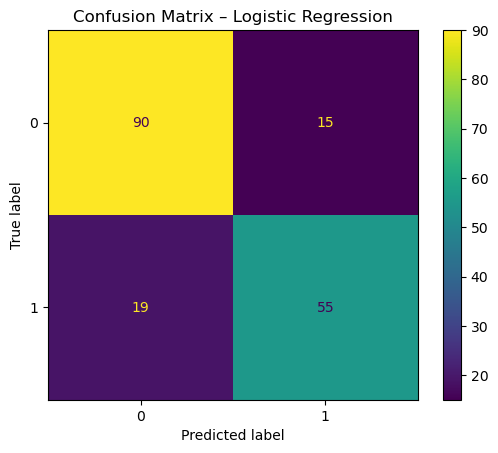

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

lr_pipeline = Pipeline([('preprocess', preprocessor), ('classifier', LogisticRegression(max_iter=1000))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", acc_lr)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

The model achieved an accuracy of 81%, correctly identifying most survivors and non-survivors. The confusion matrix shows that the model performs slightly better at predicting non-survival, with some surviving passengers being misclassified.

### Training on a Random Forest 
Logistic Regression has its limits, however, it cannot capture non-linear relationships. That's why a Random Forest was chosen to try to improve the model further. Using the same preprocessed pipeline, the model gets fitted, and then the accuracy gets calculated next to a Confusion Matrix again. 

Random Forest Accuracy: 0.8044692737430168


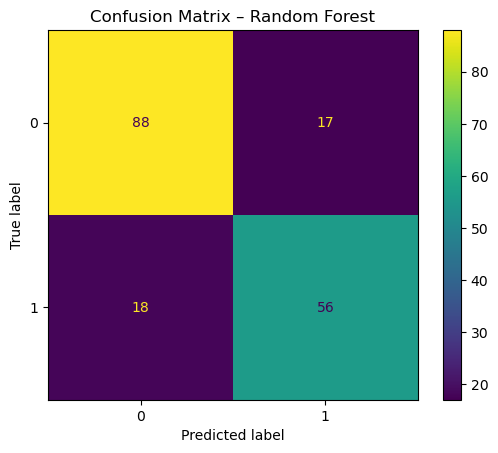

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([('preprocess', preprocessor), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])
rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Confusion Matrix – Random Forest")
plt.show()

With 80.4%, the Random Forest model achieved close to no difference in accuracy compared to Logistic Regression and produced a very similar Confusion Matrix. This suggests that nearly all of the patterns are already captured by simple, linear relationships.

One issue is that the model is dependent on the specific test-train split. Therefore, cross validation is used too, to get a more reliable estimate of the model's performance. 

In [7]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy')

print("Random Forest CV Accuracy (mean):", cv_scores.mean())

Random Forest CV Accuracy (mean): 0.7991923569388358


Cross Validation found a mean accuracy of 80%, providing a more stable and representative estimate of how the model is expected to perform on unseen data.

### Final Thoughts
When we compare the results of the Linear Regression model and the Random Forest, we can conclude that Linear Regression already covered most of the patterns, and that there are close to no non-linear patterns in the data. To increase accuracy, the next step would probably be to include more features by carefully feature engineering them. For example, extracting passenger titles from names or creating family-related features could provide additional predictive signals. We ran into the issue that the results differed from session to session because of a different random state, messing up the interpretations. We fixed this by defining the random state, and it made us more aware of the importance of Cross_validation for stable results. 